In [1]:
from collections import Counter
import numpy as np
import pysam
from scipy import stats
import click
import pyranges as pr
from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict
import pandas as pd
from scipy.stats import variation, gaussian_kde, pearsonr, mannwhitneyu

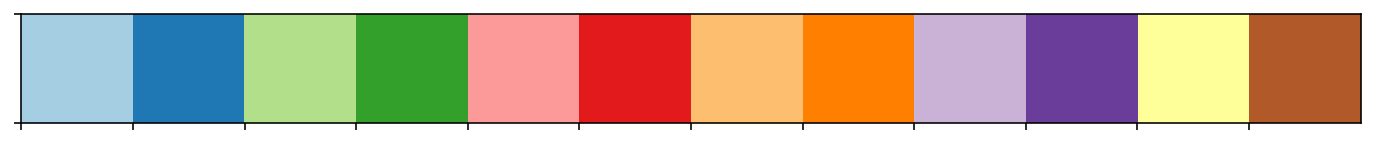

In [548]:
# 加载画图包
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import seaborn as sns

# 设置全局字体
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

# setting color palette
pal = sns.color_palette("Paired")
sns.set_palette(pal)
sns.palplot(pal)

In [3]:
# 读取代表性转录本gene_model
araport11_isoform_path = '/public/home/mowp/db/Arabidopsis_thaliana/representative_gene_model/araport11.representative.gene_model.bed'
araport11_isoform = pd.read_csv(araport11_isoform_path, sep='\t', 
                                names=['chrom', 'chromStart', 'chromEnd', 'name', 
                                       'score', 'strand', 'thickStart', 'thickEnd', 
                                       'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
                               )
araport11_isoform['gene_id'] = araport11_isoform['name'].map(lambda x: x.split('.')[0])
araport11_isoform.set_index('gene_id', inplace=True)

In [4]:
coding_gene = '/public/home/mowp/db/Arabidopsis_thaliana/bed/Araport11_protein_coding.201606.bed'
coding_gene = pr.read_bed(coding_gene, as_df=True)
coding_gene = set(coding_gene['Name'].map(lambda x: x.split('.')[0]))

# get APA

In [5]:
polya_cluster = '/public/home/mowp/data/total_RNA/nanopore_cdna/polya_sites/nanopore_cdna.polya_cluster.bed'
polya_cluster = pr.read_bed(polya_cluster, as_df=True)
polya_cluster['gene_id'] = polya_cluster.Name.map(lambda x: x.split('_')[0])

In [475]:
item

array([5, 26944100, 26944164, 'AT5G67530_2', 13, '+', 2.873, 'AT5G67530'],
      dtype=object)

In [359]:
# 筛选有两个polya site的基因
apa_count = polya_cluster.groupby('gene_id').apply(len)
apa_gene = list(apa_count[apa_count == 2].index)
mask = polya_cluster['gene_id'].isin(apa_gene)

In [68]:
STRAND_TO_BOOL = {'-': True, '+': False}
def get_APA_polya_len(infile, gene_id, apa):
    '''
    获取同一基因不同APA isoform的polya长度
        apa: array([1, 64279, 64360, 'AT1G01140_1', 100, '-'], dtype=object)
    '''
    chrom, start, end, *_, gene_strand = apa
    chrom = str(chrom)
    gene_strand = STRAND_TO_BOOL[gene_strand]
    polya_len_list = []

    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end+1):
            polya_len = read.get_tag('pa')
            read_gene_id = read.get_tag('gi')
            
            if read_gene_id != gene_id:
                continue
            
            three_prime_end = read.reference_start if gene_strand else read.reference_end
            if start <= three_prime_end <= end+1:
                polya_len_list.append(polya_len)

    return polya_len_list, gene_id

In [342]:
# multi run

infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.polyadenylated.bam'

d_results, p_results = [], []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id, df in polya_cluster[mask].groupby('gene_id'):
        p_apa = df.iloc[0].values[:6]
        d_apa = df.iloc[1].values[:6]
        if (p_apa[-1] == '+' and d_apa[1] - p_apa[2] < 100) \
            or (p_apa[-1] == '-' and p_apa[1] - d_apa[2] < 100):
            p_results.append(e.submit(get_APA_polya_len, infile, gene_id, p_apa))
            d_results.append(e.submit(get_APA_polya_len, infile, gene_id, d_apa))

In [343]:
polya_results = []
for p_apa, d_apa in zip(p_results, d_results):
    p_apa, gene_id = p_apa.result()
    d_apa, _ = d_apa.result()
    polya_results.append([np.median(p_apa), len(p_apa), np.median(d_apa), len(d_apa), gene_id])

In [344]:
apa_polya_df = pd.DataFrame(polya_results, columns=['p_pas', 'len_p_pas', 'd_pas', 'len_d_pas', 'gene_id'])

In [345]:
apa_polya_df.dropna(inplace=True)

In [346]:
apa_polya_df

,p_pas,len_p_pas,d_pas,len_d_pas,gene_id
0,116.029999,100,122.980003,87,AT1G01140
1,116.020000,8,137.550003,20,AT1G01200
2,110.714996,42,112.300003,11,AT1G01260
3,117.199997,18,90.820000,21,AT1G01305
4,102.040001,81,93.489998,113,AT1G01490
...,...,...,...,...,...
2047,107.799999,12,90.720001,13,AT5G67350
2048,81.094997,22,109.139999,41,AT5G67390
2049,105.519997,33,101.129997,143,AT5G67420
2050,87.289997,36,105.920002,40,AT5G67460


In [347]:
# Calculate the point density
xy = np.vstack([apa_polya_df['p_pas'], apa_polya_df['d_pas']])
color = gaussian_kde(xy)(xy)

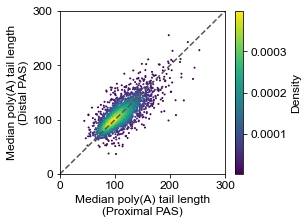

In [348]:
plt.figure(figsize=(3.7, 3))
plt.scatter(x=apa_polya_df['p_pas'], y=apa_polya_df['d_pas'], s=1, c=color)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.plot([0, 300], [0, 300], color='#555555', ls='--')
plt.xlabel('Median poly(A) tail length\n(Proximal PAS)')
plt.ylabel('Median poly(A) tail length\n(Distal PAS)')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])
colorbar = plt.colorbar()
colorbar.set_label("Density")

In [ ]:
df_ = apa_polya_df.loc[:, ['p_pas', 'd_pas',]].melt(var_name='type', value_name='polya_len')
plt.figure(figsize=(3, 3))
sns.violinplot(x='type', y='polya_len', data=df_, width=.5,)
plt.xticks([0, 1], ['Proximal PAS', 'Distal PAS'])
plt.ylabel('Median poly(A) tail length (nt)')
plt.xlabel(None)

In [350]:
print(f'Proximal PAS = {np.median(apa_polya_df["p_pas"]):.2f}')
print(f'Distal PAS = {np.median(apa_polya_df["d_pas"]):.2f}')

Proximal PAS = 108.26
Distal PAS = 108.10


In [351]:
mannwhitneyu(apa_polya_df['p_pas'], apa_polya_df['d_pas'])

MannwhitneyuResult(statistic=2099982.5, pvalue=0.44375116306271645)

## single gene

In [677]:
gene_id = 'AT5G66052'
df = polya_cluster.query('gene_id == @gene_id')
df

,Chromosome,Start,End,Name,Score,Strand,ThickStart,gene_id
20569,5,26416560,26416659,AT5G66052_1,36,+,3.365,AT5G66052
20570,5,26416908,26416952,AT5G66052_2,174,+,3.605,AT5G66052


In [678]:
p_apa = df.iloc[0].values[:6]
d_apa = df.iloc[1].values[:6]
if (p_apa[-1] == '+' and d_apa[1] - p_apa[2] > 100) \
    or (p_apa[-1] == '-' and p_apa[1] - d_apa[2] > 100):
    p_results = get_APA_polya_len(infile, gene_id, p_apa)[0]
    d_results = get_APA_polya_len(infile, gene_id, d_apa)[0]

In [679]:
d_results = np.array(d_results)
d_results = d_results[d_results<300]

In [680]:
df1 = pd.DataFrame(p_results, columns=['polya_len'])
df1['type'] = 'p_pas'
df2 = pd.DataFrame(d_results, columns=['polya_len'])
df2['type'] = 'd_pas'
df = pd.concat([df1, df2])
del df1, df2

Text(0.5, 0, '')

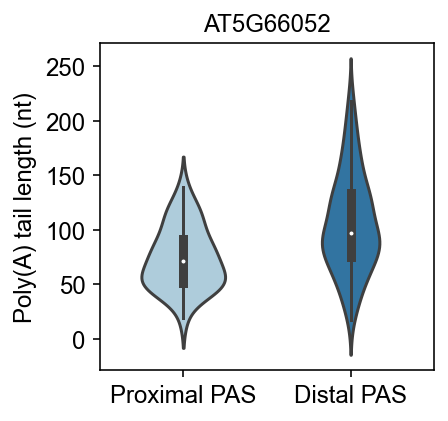

In [681]:
plt.figure(figsize=(3, 3))
plt.title(gene_id, size='medium')
sns.violinplot(x='type', y='polya_len', data=df, width=.5)
plt.ylabel('Poly(A) tail length (nt)')
plt.xticks([0, 1], ['Proximal PAS', 'Distal PAS'])
plt.xlabel(None)

In [442]:
print(f'Proximal PAS = {np.median(p_results):.2f}, n={len(p_results)}')
print(f'Distal PAS = {np.median(d_results):.2f}, n={len(d_results)}')

Proximal PAS = 71.11, n=36
Distal PAS = 97.18, n=171


In [443]:
mannwhitneyu(p_results, d_results)

MannwhitneyuResult(statistic=1711.5, pvalue=1.4462208124586428e-05)

In [445]:
from scipy import stats

In [456]:
stats.ks_2samp(np.array(p_results), np.array(d_results))

KstestResult(statistic=0.358187134502924, pvalue=0.0006591873626995426)

In [455]:
stats.ks_2samp(np.array(p_results)*2, np.array(d_results)*2)

KstestResult(statistic=0.358187134502924, pvalue=0.0006591873626995426)

In [452]:
stats.shapiro(p_results)

ShapiroResult(statistic=0.9561555981636047, pvalue=0.1632484495639801)

In [453]:
stats.shapiro(d_results)

ShapiroResult(statistic=0.9778321385383606, pvalue=0.007758903782814741)

# CR-APA

In [332]:
STRAND_TO_BOOL = {'-': True, '+': False}
def get_CR_APA_polya_len(infile, gene_id, apa):
    '''
    获取同一基因不同APA isoform的polya长度
        apa: array([1, 64279, 64360, 'AT1G01140_1', 100, '-'], dtype=object)
    '''
    polya_len_list = []
    for apa_ in apa:
        chrom, start, end, *_, gene_strand = apa_
        chrom = str(chrom)
        gene_strand = STRAND_TO_BOOL[gene_strand]

        with pysam.AlignmentFile(infile, 'rb') as inbam:
            for read in inbam.fetch(chrom, start, end+1):
                polya_len = read.get_tag('pa')
                read_gene_id = read.get_tag('gi')

                if read_gene_id != gene_id:
                    continue

                three_prime_end = read.reference_start if gene_strand else read.reference_end
                if start <= three_prime_end <= end+1:
                    polya_len_list.append(polya_len)

    return polya_len_list, gene_id

In [457]:
# 筛选APA的基因
apa_count = polya_cluster.groupby('gene_id').apply(len)
apa_gene = list(apa_count[apa_count >= 2].index)
mask = polya_cluster['gene_id'].isin(apa_gene)

In [543]:
# multi run

cr_apa_gene = set()
cr_results, utr_results = [], []
with ProcessPoolExecutor(max_workers=64) as e:
    for gene_id, df in polya_cluster[mask].groupby('gene_id'):
        if gene_id not in coding_gene:
            continue
        utr_apa, cr_apa = [], []
        for item in df.values:
            apa = item[:6]
            gene_id = item[-1]
            if (apa[5] == '+' and apa[2] < araport11_isoform.loc[gene_id, 'thickEnd']) \
                or (apa[5] == '-' and apa[1] > araport11_isoform.loc[gene_id, 'thickStart']+1):
                cr_apa_gene.add(gene_id)
                cr_apa.append(apa)

            elif (apa[5] == '+' and apa[2] > araport11_isoform.loc[gene_id, 'thickEnd']) \
                or (apa[5] == '-' and apa[1] < araport11_isoform.loc[gene_id, 'thickStart']+1):
                utr_apa.append(apa)

        if len(cr_apa) >= 1 and len(utr_apa) >= 1:
            cr_results.append(e.submit(get_CR_APA_polya_len, infile, gene_id, cr_apa))
            utr_results.append(e.submit(get_CR_APA_polya_len, infile, gene_id, utr_apa))

In [544]:
polya_results = []
for cr_apa, utr_apa in zip(cr_results, utr_results):
    cr_apa, gene_id = cr_apa.result()
    utr_apa, _ = utr_apa.result()
    p_value = -np.log10(mannwhitneyu(cr_apa, utr_apa)[1])
    polya_results.append([np.median(cr_apa), len(cr_apa), np.median(utr_apa), len(utr_apa), p_value, gene_id])

In [545]:
apa_polya_df = pd.DataFrame(polya_results, columns=['cr_apa', 'len_cr_apa', 'utr_apa', 'len_utr_apa', 'p_value', 'gene_id'])

In [546]:
apa_polya_df['p_value_color'] = apa_polya_df['p_value'].map(lambda x: 0 if x < 2 else 1)

In [464]:
apa_polya_df.query('len_cr_apa < len_utr_apa')

,cr_apa,len_cr_apa,utr_apa,len_utr_apa,p_value,gene_id,p_value_color
1,87.080002,23,112.279999,181,0.414587,AT1G02090,0
3,183.300003,9,126.879997,13,0.635817,AT1G06490,0
7,83.695000,68,90.900002,97,0.892515,AT1G13190,0
8,106.669998,11,166.000000,93,2.213058,AT1G15030,1
11,167.750000,13,117.809998,19,1.340262,AT1G22400,0
...,...,...,...,...,...,...,...
108,83.669998,15,111.805000,84,1.445050,AT5G47455,0
109,103.950001,14,121.620003,93,0.909546,AT5G54250,0
110,99.059998,31,112.705002,162,1.202241,AT5G57180,0
111,101.130001,46,131.970001,117,4.463324,AT5G58040,1


In [453]:
# Calculate the point density
xy = np.vstack([apa_polya_df['cr_apa'], apa_polya_df['utr_apa']])
color = gaussian_kde(xy)(xy)

Text(0.5, 1.0, 'Median poly(A) tail (nt)')

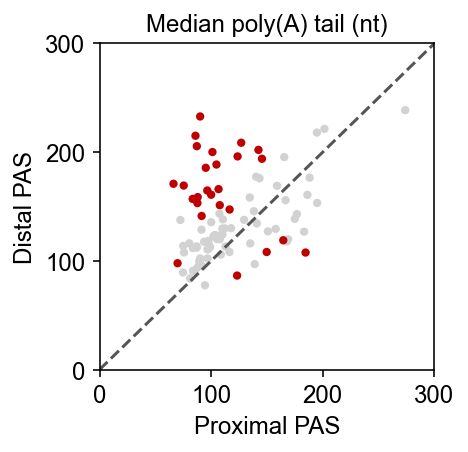

In [549]:
# CR-APA

plt.figure(figsize=(3, 3))
plt.scatter(
    x=apa_polya_df['cr_apa'], 
    y=apa_polya_df['utr_apa'], 
    s=10, 
    c=apa_polya_df['p_value_color'],
#     cmap=plt.cm.get_cmap('Reds'),
    cmap=mpl.colors.ListedColormap(['#D2D2D2', '#C00000']),
)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.plot([0, 300], [0, 300], color='#555555', ls='--')
plt.xlabel('Proximal PAS')
plt.ylabel('Distal PAS')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])
plt.title('Median poly(A) tail (nt)', size='medium')

Text(0.5, 1.0, 'Median poly(A) tail (nt)')

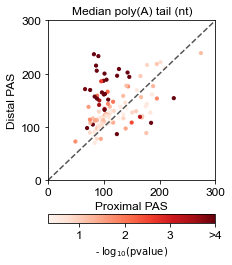

In [510]:
# CR-APA

plt.figure(figsize=(3, 4.2))
plt.scatter(
    x=apa_polya_df['cr_apa'], 
    y=apa_polya_df['utr_apa'], 
    s=10, 
    c=apa_polya_df['p_value'],
    cmap=plt.cm.get_cmap('Reds'),
    vmax=4
)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.plot([0, 300], [0, 300], color='#555555', ls='--')
plt.xlabel('Proximal PAS')
plt.ylabel('Distal PAS')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])
colorbar = plt.colorbar(orientation="horizontal")
colorbar.set_ticks([1, 2, 3, 4])
colorbar.set_ticklabels([1, 2, 3, '>4'])
colorbar.set_label("- $\log_{10}\mathrm{(pvalue)}$", size='small')
plt.title('Median poly(A) tail (nt)', size='medium')

Text(0.5, 1.0, 'CR-APA')

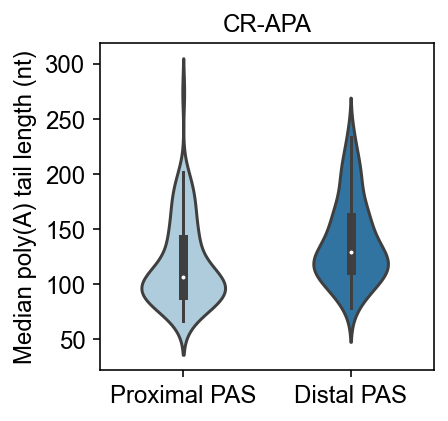

In [550]:
df_ = apa_polya_df.loc[:, ['cr_apa', 'utr_apa',]].melt(var_name='type', value_name='polya_len')
plt.figure(figsize=(3, 3))
sns.violinplot(x='type', y='polya_len', data=df_, width=.5, palette=pal)
plt.xticks([0, 1], ['Proximal PAS', 'Distal PAS'])
plt.ylabel('Median poly(A) tail length (nt)')
plt.xlabel(None)
plt.title('CR-APA', size='medium')

In [466]:
mannwhitneyu(apa_polya_df['cr_apa'], apa_polya_df['utr_apa'])

MannwhitneyuResult(statistic=4285.0, pvalue=1.994678043985873e-06)

In [473]:
print(f'Proximal = {np.median(apa_polya_df["cr_apa"]):.2f}, n={len(apa_polya_df["utr_apa"])}')
print(f'Distal = {np.median(apa_polya_df["utr_apa"]):.2f}, n={len(apa_polya_df["utr_apa"])}')

Proximal = 104.77, n=115
Distal = 126.88, n=115


## single gene

In [552]:
gene_id = 'AT2G43410'

utr_apa, cr_apa = [], []
for item in polya_cluster[mask].query('gene_id == @gene_id').values:
    apa = item[:6]
    gene_id = item[-1]
    
    if (apa[5] == '+' and apa[2] < araport11_isoform.loc[gene_id, 'thickEnd']) \
        or (apa[5] == '-' and apa[1] > araport11_isoform.loc[gene_id, 'thickStart']+1):
        cr_apa.append(apa)

    elif (apa[5] == '+' and apa[2] > araport11_isoform.loc[gene_id, 'thickEnd']) \
        or (apa[5] == '-' and apa[1] < araport11_isoform.loc[gene_id, 'thickStart']+1):
        utr_apa.append(apa)

if len(cr_apa) >= 1 and len(utr_apa) >= 1:
    cr_results_ = get_CR_APA_polya_len(infile, gene_id, cr_apa)[0]
    utr_results_ = get_CR_APA_polya_len(infile, gene_id, utr_apa)[0]

In [553]:
cr_results_ = np.array(cr_results_)
cr_results_ = cr_results_[cr_results_<300]

In [554]:
df1 = pd.DataFrame(cr_results_, columns=['polya_len'])
df1['type'] = 'Proximal PAS'
df2 = pd.DataFrame(utr_results_, columns=['polya_len'])
df2['type'] = 'Distal PAS'
df = pd.concat([df1, df2])
del df1, df2

Text(0.5, 1.0, 'AT2G43410')

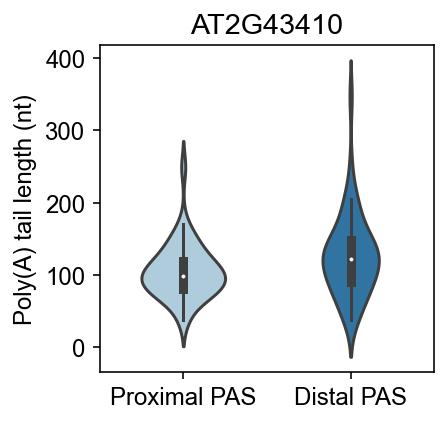

In [555]:
plt.figure(figsize=(3, 3))
sns.violinplot(x='type', y='polya_len', data=df, width=.5,)
plt.ylabel('Poly(A) tail length (nt)')
plt.xticks([0, 1], ['Proximal PAS', 'Distal PAS'])
plt.xlabel(None)
plt.title(gene_id)

In [330]:
mannwhitneyu(cr_results_, utr_results_)

MannwhitneyuResult(statistic=775.0, pvalue=0.018613834721067875)

In [331]:
print(f'Proximal PAS = {np.median(cr_results_):.2f}, n={len(cr_results_)}')
print(f'Distal PAS = {np.median(utr_results_):.2f}, n={len(utr_results_)}')

Proximal PAS = 99.45, n=40
Distal PAS = 122.63, n=52


# UTR-APA

In [526]:
STRAND_TO_BOOL = {'-': True, '+': False}
def get_UTR_APA_polya_len(infile, gene_id, apa):
    '''
    获取同一基因不同APA isoform的polya长度
        apa: array([1, 64279, 64360, 'AT1G01140_1', 100, '-'], dtype=object)
    '''
    chrom, start, end, *_, gene_strand = apa
    chrom = str(chrom)
    gene_strand = STRAND_TO_BOOL[gene_strand]
    polya_len_list = []

    with pysam.AlignmentFile(infile, 'rb') as inbam:
        for read in inbam.fetch(chrom, start, end+1):
            polya_len = read.get_tag('pa')
            read_gene_id = read.get_tag('gi')
            
            if read_gene_id != gene_id:
                continue
            
            three_prime_end = read.reference_start if gene_strand else read.reference_end
            if start <= three_prime_end <= end+1:
                polya_len_list.append(polya_len)

    return polya_len_list, gene_id

In [556]:
# 筛选APA的基因
apa_count = polya_cluster.groupby('gene_id').apply(len)
apa_gene = list(apa_count[apa_count == 2].index)
mask = polya_cluster['gene_id'].isin(apa_gene)

In [557]:
# multi run

infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.polyadenylated.bam'

d_apa_result, p_apa_result, distance_result = [], [], []
with ProcessPoolExecutor(max_workers=64) as e:
    
    for gene_id, df in polya_cluster[mask].groupby('gene_id'):
        if gene_id not in coding_gene:
            continue
        p_apa, d_apa = None, None
        for item in df.values:
            apa = item[:6]
            # apa = array([5, 26416560, 26416659, 'AT5G66052_1', 36, '+'], dtype=object)
            gene_id = item[-1]

            if (apa[5] == '+' and apa[2] > araport11_isoform.loc[gene_id, 'thickEnd']) \
                or (apa[5] == '-' and apa[1] < araport11_isoform.loc[gene_id, 'thickStart']+1):
                if p_apa is None:
                    p_apa = apa
                else:
                    d_apa = apa

        if p_apa is not None and d_apa is not None:
            p_apa_result.append(e.submit(get_UTR_APA_polya_len, infile, gene_id, p_apa))
            d_apa_result.append(e.submit(get_UTR_APA_polya_len, infile, gene_id, d_apa))
            if p_apa[-1] == '+':
                distance_result.append(d_apa[1] - p_apa[2])
            else:
                distance_result.append(p_apa[1] - d_apa[2])

In [75]:
p_apa

array([5, 26416560, 26416659, 'AT5G66052_1', 36, '+'], dtype=object)

In [662]:
polya_results = []
n = 0
for p_apa, d_apa, distance in zip(p_apa_result, d_apa_result, distance_result):
    p_apa, gene_id = p_apa.result()
    d_apa, _ = d_apa.result()
    if len(p_apa) >= 10 and len(d_apa) >= 10:
        p_value = -np.log10(mannwhitneyu(p_apa, d_apa)[1])
        n += 1
        polya_results.append([np.median(p_apa), len(p_apa), np.median(d_apa), len(d_apa), distance, p_value, gene_id])
print(n)

1762


In [663]:
apa_polya_df = pd.DataFrame(polya_results, columns=['p_pas', 'len_p_pas', 'd_pas', 'len_d_pas', 'distance', 'p_value','gene_id'])

In [664]:
apa_polya_df

,p_pas,len_p_pas,d_pas,len_d_pas,distance,p_value,gene_id
0,116.029999,100,122.980003,87,67,0.667785,AT1G01140
1,110.714996,42,112.300003,11,33,0.445240,AT1G01260
2,117.199997,18,90.820000,21,25,2.030225,AT1G01305
3,102.040001,81,93.489998,113,45,0.491868,AT1G01490
4,100.980003,37,93.339996,33,44,1.055389,AT1G01500
...,...,...,...,...,...,...,...
1757,107.799999,12,90.720001,13,66,0.441487,AT5G67350
1758,81.094997,22,109.139999,41,33,1.109119,AT5G67390
1759,105.519997,33,101.129997,143,61,0.340095,AT5G67420
1760,87.289997,36,105.920002,40,34,2.004616,AT5G67460


In [659]:
# def get_p_value_color(df):
#     if df['p_value'] < 2:
#         return 0
#     if df['p_pas'] < df['d_pas']:
#         return -1
#     else:
#         return 1

def get_p_value_color(df):
    if df['p_value'] < 2:
        return 0
    else:
        return 1

In [665]:
apa_polya_df['p_value_color'] = apa_polya_df.apply(get_p_value_color, axis=1)

In [676]:
len(apa_polya_df.query('p_value >= 2'))

109

In [668]:
len(apa_polya_df.query('p_pas > d_pas & p_value > 2'))

38

In [669]:
len(apa_polya_df.query('p_pas < d_pas & p_value > 2'))

71

In [58]:
# Calculate the point density
xy = np.vstack([apa_polya_df['p_pas'], apa_polya_df['d_pas']])
color = gaussian_kde(xy)(xy)

Text(0.5, 1.0, 'Median poly(A) tail (nt)')

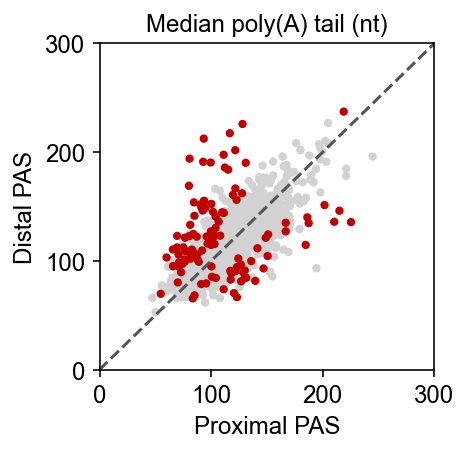

In [666]:
plt.figure(figsize=(3, 3))

apa_polya_df_ = apa_polya_df.sort_values(by=['p_value'])
plt.scatter(
    x=apa_polya_df_['p_pas'], 
    y=apa_polya_df_['d_pas'], 
    s=10, 
    c=apa_polya_df_['p_value_color'],
    cmap=mpl.colors.ListedColormap(['#D2D2D2', '#C00000']),
)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.plot([0, 300], [0, 300], color='#555555', ls='--')
plt.xlabel('Proximal PAS')
plt.ylabel('Distal PAS')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])

plt.title('Median poly(A) tail (nt)', size='medium')
# plt.title('UTR-APA')
# plt.tight_layout()

Text(0.5, 1.0, 'Median poly(A) tail (nt)')

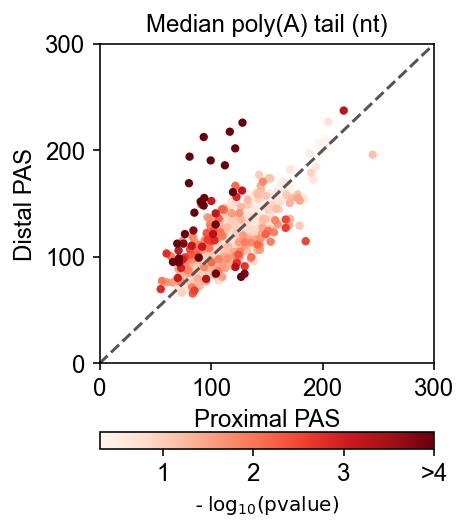

In [598]:
plt.figure(figsize=(3, 4.2))

apa_polya_df_ = apa_polya_df.sort_values(by=['p_value'])
plt.scatter(
    x=apa_polya_df_['p_pas'], 
    y=apa_polya_df_['d_pas'], 
    s=10, 
    c=apa_polya_df_['p_value'], 
    cmap=plt.cm.get_cmap('Reds'),
    vmax=4,
)
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.plot([0, 300], [0, 300], color='#555555', ls='--')
plt.xlabel('Proximal PAS')
plt.ylabel('Distal PAS')
plt.xticks([0, 100, 200, 300])
plt.yticks([0, 100, 200, 300])
colorbar = plt.colorbar(orientation="horizontal")
colorbar.set_ticks([1, 2, 3, 4])
colorbar.set_ticklabels([1, 2, 3, '>4'])
colorbar.set_label("- $\log_{10}\mathrm{(pvalue)}$", size='small')
plt.title('Median poly(A) tail (nt)', size='medium')
# plt.title('UTR-APA')
# plt.tight_layout()

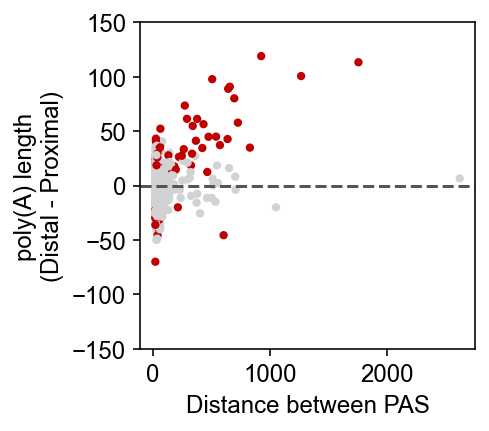

In [634]:
plt.figure(figsize=(3, 3))

apa_polya_df_ = apa_polya_df.sort_values(by=['p_value'])
plt.scatter(
    y=apa_polya_df['d_pas']-apa_polya_df_['p_pas'], 
    x=apa_polya_df['distance'], 
    s=10, 
    c=apa_polya_df['p_value_color'],
    cmap=mpl.colors.ListedColormap(['#D2D2D2', '#C00000']),
)
# plt.xlim(0, 300)
plt.ylim(-150, 150)
plt.axhline(0, ls='--', color='#555555')
plt.xlabel('Distance between PAS')
plt.ylabel('poly(A) length\n(Distal - Proximal)');

# colorbar.set_label("- $\log_{10}\mathrm{(pvalue)}$")
# plt.title('UTR-APA')

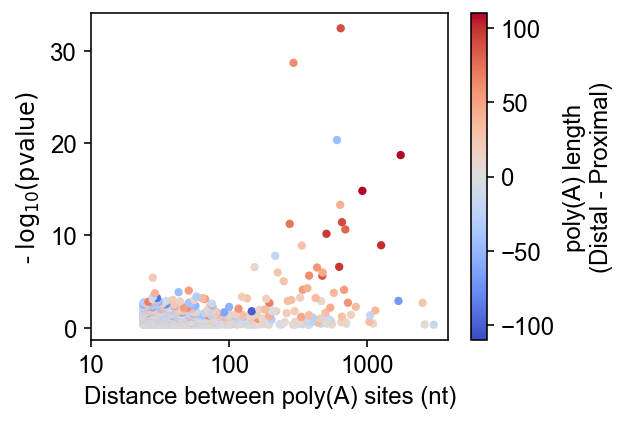

In [671]:
plt.figure(figsize=(4, 3))

apa_polya_df_ = apa_polya_df.sort_values(by=['p_value'])
plt.scatter(
    x=np.log10(apa_polya_df_['distance']), 
    y=apa_polya_df_['p_value'],
    s=10, 
    c=apa_polya_df_['d_pas']-apa_polya_df_['p_pas'], 
    cmap=plt.cm.get_cmap('coolwarm'),
    vmin=-110,
    vmax=110,
)
# plt.xlim(0, 300)
# plt.ylim(0, 300)
# plt.axhline(2, ls='--', color='#555555')
plt.xlabel('Distance between poly(A) sites (nt)')
plt.ylabel('- $\log_{10}\mathrm{(pvalue)}$')
# plt.ylabel('Median poly(A) tail length\n(Distal PAS)')
plt.xticks([1, 2, 3], [10, 100, 1000])
colorbar = plt.colorbar()
# colorbar.set_ticks([1, 2, 3, 4])
# colorbar.set_ticklabels([1, 2, 3, '>4'])
colorbar.set_label('poly(A) length\n(Distal - Proximal)')
# colorbar.set_label("- $\log_{10}\mathrm{(pvalue)}$")
# plt.title('UTR-APA')

Text(0.5, 1.0, 'UTR-APA')

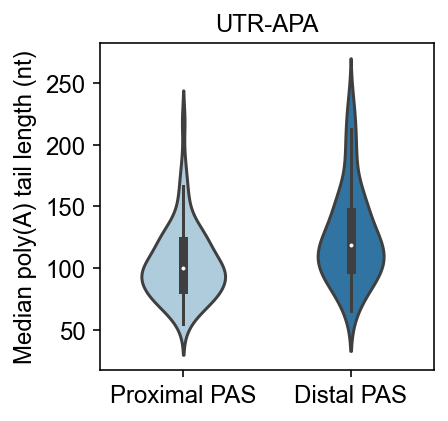

In [651]:
apa_polya_df_ = apa_polya_df.query('p_value > 2')
df_ = apa_polya_df_.loc[:, ['p_pas', 'd_pas',]].melt(var_name='type', value_name='polya_len')
plt.figure(figsize=(3, 3))
sns.violinplot(x='type', y='polya_len', data=df_, width=.5,)
plt.xticks([0, 1], ['Proximal PAS', 'Distal PAS'])
plt.ylabel('Median poly(A) tail length (nt)')
plt.xlabel(None)
plt.title('UTR-APA', size='medium')

In [652]:
mannwhitneyu(apa_polya_df_['p_pas'], apa_polya_df_['d_pas'])

MannwhitneyuResult(statistic=1634.0, pvalue=6.519585111201488e-05)

In [653]:
print(f'Proximal = {np.median(apa_polya_df_["p_pas"]):.2f}, n={len(apa_polya_df_["p_pas"])}')
print(f'Distal = {np.median(apa_polya_df_["d_pas"]):.2f}, n={len(apa_polya_df_["d_pas"])}')

Proximal = 99.69, n=72
Distal = 118.40, n=72


# utr length vs polya length

In [8]:
polya_sites = '/public/home/mowp/data/total_RNA/nanopore_cdna/polya_sites/nanopore_cdna.polya_cluster.summit.bed'
polya_sites = pr.read_bed(polya_sites, as_df=True)

In [9]:
def get_utr_len(pac_name, gene_id):
    pas_data = polya_sites.query('Name == @pac_name').values[0]
    pas = pas_data[2]
    strand = pas_data[5]
    
    if strand == '+':
        return pas-araport11_isoform.at[gene_id, 'thickEnd']
    else:
        return araport11_isoform.at[gene_id, 'thickStart']-pas+1

In [260]:
# multi run

infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.polyadenylated.bam'

apa_result = []
utr_len = []
with ProcessPoolExecutor(max_workers=64) as e:
    
    for gene_id, df in polya_cluster.groupby('gene_id'):
        if gene_id not in coding_gene:
            continue

        for item in df.values:
            apa = item[:6]
            if (apa[5] == '+' and apa[2] > araport11_isoform.loc[gene_id, 'thickEnd']) \
                or (apa[5] == '-' and apa[1] < araport11_isoform.loc[gene_id, 'thickStart']+1):
                apa_result.append(e.submit(get_UTR_APA_polya_len, infile, gene_id, apa))
                utr_len.append(e.submit(get_utr_len,apa[3], gene_id))

In [261]:
polya_results = []
for polya_len, utr_len_ in zip(apa_result, utr_len):
    polya_len, gene_id = polya_len.result()
    utr_len_ = utr_len_.result()
    if len(polya_len) >= 10:
        polya_results.append([np.median(polya_len), len(polya_len), utr_len_, gene_id])

In [262]:
polya_len_with_utr_len = pd.DataFrame(polya_results, columns=['polya_len', 'counts', 'utr_len', 'gene_id'])

In [272]:
polya_len_with_utr_len = polya_len_with_utr_len.query('utr_len > 0')

In [274]:
polya_len_with_utr_len['log10_utr_len'] = np.log10(polya_len_with_utr_len['utr_len'])

In [273]:
# Calculate the point density
xy = np.vstack([polya_len_with_utr_len['polya_len'], polya_len_with_utr_len['log10_utr_len']])
color = gaussian_kde(xy)(xy)

Text(0.5, 0, "3' UTR length")

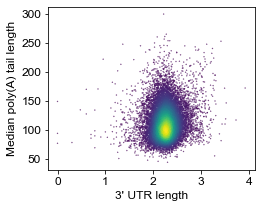

In [275]:
plt.figure(figsize=(3.7, 3))
plt.scatter(y=polya_len_with_utr_len['polya_len'], x=polya_len_with_utr_len['log10_utr_len'], s=.1, c=color)
# plt.ylim(0, 300)
# plt.xlim(0, 1000)
# plt.plot([0, 300], [0, 300], color='#555555', ls='--')
plt.ylabel('Median poly(A) tail length')
plt.xlabel('3\' UTR length')
# plt.xticks([0, 100, 200, 300])
# plt.yticks([0, 100, 200, 300])
# colorbar = plt.colorbar()
# colorbar.set_label("Density")
# plt.title('UTR-APA')

In [276]:
polya_len_with_utr_len.corr()

,polya_len,counts,utr_len,log10_utr_len
polya_len,1.000000,-0.124756,0.121689,0.095561
counts,-0.124756,1.000000,-0.023875,-0.015381
utr_len,0.121689,-0.023875,1.000000,0.776496
log10_utr_len,0.095561,-0.015381,0.776496,1.000000


# polyadenylation diversity

In [364]:
# multi run

infile = '/public/home/mowp/data/total_RNA/nanopore_cdna/polyadenylated_data/nanopore_cdna.polyadenylated.bam'
result = []
entropy = []
with ProcessPoolExecutor(max_workers=64) as e:
    for item in polya_cluster.values:
        apa = item[:6]
        gene_id = item[-1]
        entropy.append(item[-2])
        result.append(e.submit(get_APA_polya_len, infile, gene_id, apa))

In [393]:
diversity_result = []
for polya_len_res, entropy_ in zip(result, entropy):
    polya_len_list, gene_id = polya_len_res.result()
    if len(polya_len_list) >= 5:
        diversity_result.append([np.median(polya_len_list), variation(polya_len_list), entropy_])

In [394]:
df = pd.DataFrame(diversity_result, columns=['polya_len', 'cv', 'entropy'])
df.dropna(inplace=True)

Text(0, 0.5, 'CV of poly(A) tail length')

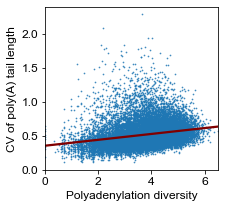

In [395]:
plt.figure(figsize=(3.1, 3))
sns.regplot(
    x="entropy", 
    y="cv", 
    data=df, 
    scatter_kws={'s' :.5},
    line_kws={'color': 'maroon'},
)
plt.xlabel('Polyadenylation diversity')
plt.ylabel('CV of poly(A) tail length')

In [396]:
pearsonr(df['entropy'], df['cv'])

(0.2343505877410428, 6.6511533140900405e-255)